In [74]:
import numpy as np
import matplotlib.pyplot as plt

# for data import 
from sklearn.datasets import fetch_openml, make_moons
from sklearn.model_selection import train_test_split

# introduction to PIL library for loading png images
from PIL import Image

# for random forests
from sklearn import tree

# for deep features extraction
from torchvision.models  import resnet18, ResNet18_Weights
from torchvision.models  import resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# for transforming data in order to feed the deep feature extractor
import torch
from torch.utils.data import Dataset, DataLoader

# for performing the distance in the feature representation space
from sklearn.metrics.pairwise import cosine_distances

The goal of this TP is to give an introduction to image representation and high dimensional K-NN.

# I. K-nn and importance of scaling data

1. Using `make_moons` from sklearn library, create a dataset with n_samples=1000, noise=0.25 (X are the 2D samples, y are the labels). We propose to study the effect of data scale. To do so, add 1000 and multiply by 2000 the second coordinate of X.

In [80]:
X, y = make_moons(n_samples=1000, shuffle=False, noise=0.25, random_state=0)

X[:, 1] += 1000
X[:, 1] *= 2000

2. Plot the data (using plt.scatter)

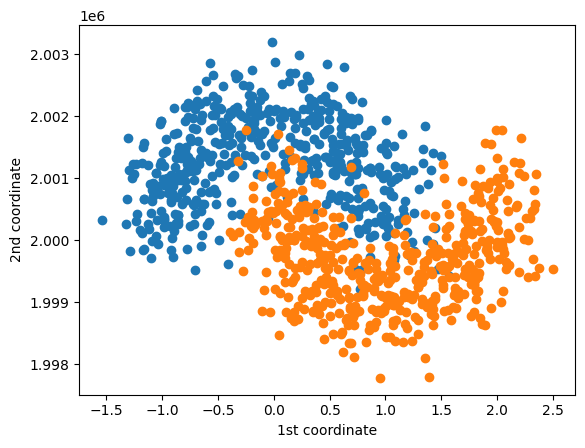

In [81]:
for lab in np.unique(y):
    plt.scatter(*X[y==lab].T)
plt.xlabel('1st coordinate')
plt.ylabel('2nd coordinate')
plt.show()

3. Using `train_test_split`, split the dataset into a "X_train", "y_train" and a "X_test", "y_test". The test_set size should be 0.3 times the train_set size.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0
)

4. Write a function get_L2 that takes X_train and X_test and returns the L2 distance between all possibles pairs of train, test samples.

In [29]:
def get_L2(X_train, X_test):
    dist = np.sqrt((X_test**2)[:, None].sum(axis=-1) + (X_train**2)[None].sum(axis=-1) - 2*X_test@X_train.T)
    return dist

In [30]:
dist = get_L2(X_train, X_test)
print(dist.shape)

(300, 700)


5. Write a function pred_NN that takes X_train, X_test, y_train and returns a numpy array of y_pred containing for each X_test's sample the label of the nearest neighbor of the considered sample in X_train.

In [31]:
def pred_NN(X_train, X_test, y_train):
    dist = get_L2(X_train, X_test)
    y_pred = y_train[np.argmin(dist, axis=-1)]
    return y_pred

In [32]:
y_pred = pred_NN(X_train, X_test, y_train)
print(y_pred.shape)

(300,)


6. Write a function get_acc that takes y_test, y_pred and returns the acccuracy of predictions.

In [33]:
def get_acc(y_test, y_pred):
    return (y_test == y_pred).sum() / len(y_test)

In [34]:
acc = get_acc(y_test, y_pred)
print(f'The accuracy of unscaled data is: {acc:.2f}')

The accuracy of unscaled data is: 0.72


7. Plot the decision boundary of the 1-NN. You can use:
* `np.linspace` to create regularly spaced elements respecitvely along the 1st-axis and the 2nd-axis
* `np.meshgrid` to create a grid of samples with the ranges defined above
* predict the label of each element of the grid using `pred_NN`
* use `plt.contourf` to plot the colors of the elements on the grid

In [35]:
Xmin = np.minimum(X_train.min(axis=0), X_test.min(axis=0))
Xmax = np.maximum(X_train.max(axis=0), X_test.max(axis=0))
x0 = np.linspace(Xmin[0], Xmax[0], 1000)
x1 = np.linspace(Xmin[1], Xmax[1], 1000)
print('x0:', x0.shape, x0.min(), x0.max())
print('x1:', x1.shape, x1.min(), x1.max())
X0, X1 = np.meshgrid(x0, x1)
print('X0:', X0.shape, X0.min(), X0.max())
print('X1:', X1.shape, X1.min(), X1.max())
Z = pred_NN(X_train, np.stack([X0.flatten(), X1.flatten()], axis=1), y_train).reshape(X0.shape)
print('Z:', Z.shape, np.unique(Z))

x0: (1000,) -1.5391224021754644 2.49546745817219
x1: (1000,) 1997779.7152910545 2003194.1003420292
X0: (1000, 1000) -1.5391224021754644 2.49546745817219
X1: (1000, 1000) 1997779.7152910545 2003194.1003420292


/tmp/ipykernel_210709/2345879113.py:2: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((X_test**2)[:, None].sum(axis=-1) + (X_train**2)[None].sum(axis=-1) - 2*X_test@X_train.T)


Z: (1000, 1000) [0 1]


In [84]:
 np.c_[X0.flatten(), X1.flatten()].shape

(100, 2)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
X0[:5,:5]

array([[-2.3089555 , -1.7988551 , -1.28875471, -0.77865432, -0.26855392],
       [-2.3089555 , -1.7988551 , -1.28875471, -0.77865432, -0.26855392],
       [-2.3089555 , -1.7988551 , -1.28875471, -0.77865432, -0.26855392],
       [-2.3089555 , -1.7988551 , -1.28875471, -0.77865432, -0.26855392],
       [-2.3089555 , -1.7988551 , -1.28875471, -0.77865432, -0.26855392]])

In [78]:
X1[:5,:5]


array([[-2.53484598, -2.53484598, -2.53484598, -2.53484598, -2.53484598],
       [-1.97635647, -1.97635647, -1.97635647, -1.97635647, -1.97635647],
       [-1.41786697, -1.41786697, -1.41786697, -1.41786697, -1.41786697],
       [-0.85937746, -0.85937746, -0.85937746, -0.85937746, -0.85937746],
       [-0.30088795, -0.30088795, -0.30088795, -0.30088795, -0.30088795]])

In [79]:
X1[:5,:5].max()

-0.3008879491372842

In [38]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [39]:
Z = neigh.predict(np.stack([X0.flatten(), X1.flatten()], axis=1)).reshape(X0.shape)

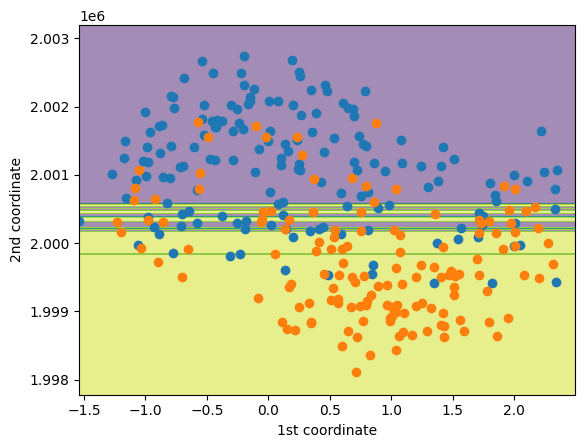

In [40]:
plt.contourf(X0, X1, Z, alpha=0.5)
for lab in np.unique(y_pred):
    plt.scatter(*X_test[y_pred==lab].T)
plt.xlabel('1st coordinate')
plt.ylabel('2nd coordinate')
plt.xlim(Xmin[0], Xmax[0])
plt.ylim(Xmin[1], Xmax[1])
plt.show()

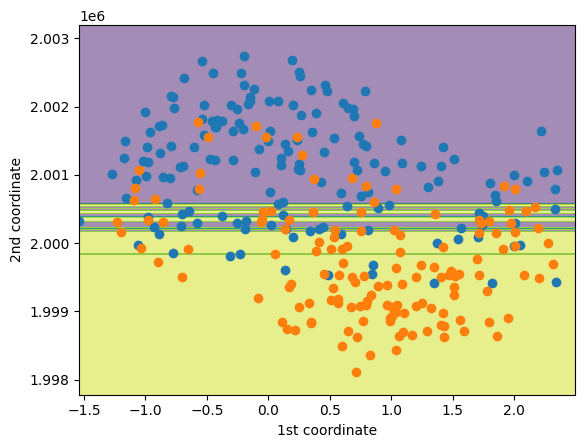

In [41]:
plt.contourf(X0, X1, Z, alpha=0.5)
for lab in np.unique(y_pred):
    plt.scatter(*X_test[y_pred==lab].T)
plt.xlabel('1st coordinate')
plt.ylabel('2nd coordinate')
plt.xlim(Xmin[0], Xmax[0])
plt.ylim(Xmin[1], Xmax[1])
plt.show()

8. Get the mean and std of X_train per axis and rescale X_train and X_test.

In [42]:
mean_train, std_train = X_train.mean(axis=0)[None], X_train.std(axis=0)[None]

X_train_scaled = (X_train - mean_train) / std_train
X_test_scaled = (X_test - mean_train) / std_train

9. What is the accuarcy of the NN-algorithm on this data ?

In [43]:
y_pred = pred_NN(X_train_scaled, X_test_scaled, y_train)
acc = get_acc(y_test, y_pred)
print(f'The accuracy of scaled data is: {acc:.2f}')

The accuracy of scaled data is: 0.91


10. Plot the decision boundary on this data.

In [44]:
Xmin = np.minimum(X_train_scaled.min(axis=0), X_test_scaled.min(axis=0))
Xmax = np.maximum(X_train_scaled.max(axis=0), X_test_scaled.max(axis=0))
x0 = np.linspace(Xmin[0], Xmax[0], 10)
x1 = np.linspace(Xmin[1], Xmax[1], 10)
print('x0:', x0.shape, x0.min(), x0.max())
print('x1:', x1.shape, x1.min(), x1.max())
X0, X1 = np.meshgrid(x0, x1)
print('X0:', X0.shape, X0.min(), X0.max())
print('X1:', X1.shape, X1.min(), X1.max())
Z = pred_NN(X_train_scaled, np.stack([X0.flatten(), X1.flatten()], axis=1), y_train).reshape(X0.shape)
print('Z:', Z.shape, np.unique(Z))

x0: (10,) -2.308955496856653 2.2819480448797638
x1: (10,) -2.534845981748154 2.4915595916263027
X0: (10, 10) -2.308955496856653 2.2819480448797638
X1: (10, 10) -2.534845981748154 2.4915595916263027
Z: (10, 10) [0 1]


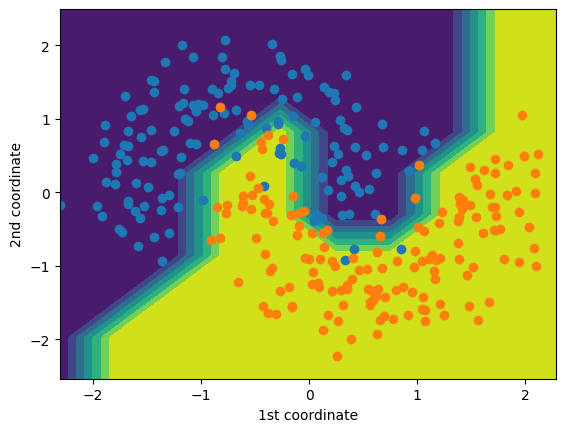

In [45]:
plt.contourf(X0, X1, Z)
for lab in np.unique(y_pred):
    plt.scatter(*X_test_scaled[y_pred==lab].T)
plt.xlabel('1st coordinate')
plt.ylabel('2nd coordinate')
plt.xlim(Xmin[0], Xmax[0])
plt.ylim(Xmin[1], Xmax[1])
plt.show()

# II. Image classification

In [46]:
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser="pandas") # Loading MNIST dataset
y = y.astype(int)

In [47]:
X.shape, X.min(), X.max()

((9298, 256), -1.0, 1.0)

1. Using `train_test_split`, split the dataset into "X_train", "y_train" and a "X_test", "y_test". The test_set size should be 0.3 times the train_set size.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=0
)

## Introduction to PIL library 

2. Convert the first image of the train set into a "PIL image" You should:
* reshape the image to $16\times 16 \times 3$ (you should repeat the image 3 times in the last axis)
* convert the numpy array to a 8bit numpy array (range between 0 and 255, then use `astype` method)
* use the function `Image.fromarray` of PIL library to convert the numpy array to a PIL image.
Show the image using `plt.imshow`

In [49]:
im0 = Image.fromarray((255*(np.repeat(X_train[0].reshape(16, 16, 1), 3, axis=-1) +1)/2).astype(np.uint8))

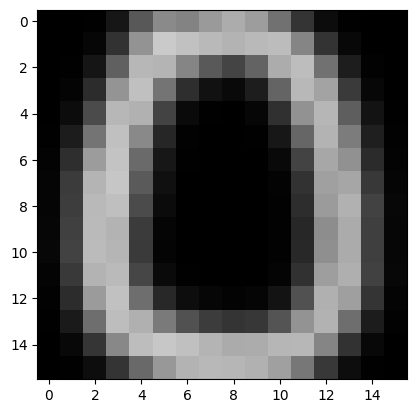

In [50]:
plt.imshow(im0)

3. Save the image using the method `save`. Import the image using `Image.open` and show.

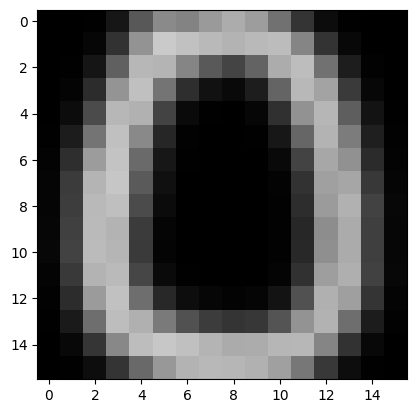

In [51]:
im0.save('im.png')
im0 = Image.open('im.png')
plt.imshow(im0)

## Random Forests

4. Use sklearn tree model to predict the class of X_test using a random forest trained on X_train and y_test.

In [52]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [53]:
y_pred = clf.predict(X_test)

5. What is the accuracy of the prediction ?

In [54]:
acc = get_acc(y_test, y_pred)
print(f'The accuracy of unscaled data is: {acc:.2f}')

The accuracy of unscaled data is: 0.87


## Nearest Neighbor

6. Apply the nearest neighbor algorithm seen in the first part of this TP to predict the class of X_test samples. (As the dataset is large and the images are high dimensional, you might have to adapt your function get_L2 to avoid memory consumption (but not necessarly...))

In [57]:
y_pred = pred_NN(X_train, X_test, y_train)

In [58]:
acc = get_acc(y_test, y_pred)
print(f'The accuracy of unscaled data is: {acc:.2f}')

The accuracy of unscaled data is: 0.97


## Introduction to Pytorch (Pretrained) Convolutional Neural Nets for image representation

7. Use `resnet18` model of pytorch with a well chosen `weights` to load the pretrained resnet18 model. Careful, to avoid memory consumption, as we will not train the  model, you should:
* use `model.eval()` method
* set the pattribute `requires_grad` of the model parameters to False

In [59]:
full_model = resnet18(weights=ResNet18_Weights.DEFAULT)
full_model.eval()
for param in full_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/lbedin/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.1MB/s]


In [60]:
full_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

8. "Cut" the previous full resnet model until the layer4. You can use `create_feature_extractor`.

In [61]:
model = create_feature_extractor(full_model, return_nodes={'layer4': 'encoding'})

In [62]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Module(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

9. The goal of this question is to check the input dimensions needed for the model.
* convert the two first images into pytorch tensors (you can first reshape the images into $3\times 16 \times 16$ and then use `torch.Tensor` function and stack the two images into a $2\times 3 \times 16 \times 16$ tensor
* compute the representations of the images using the above model

In [63]:
ims = torch.Tensor(X_test[:2, None].repeat(3, axis=1).reshape(2, 3, 16, 16))
ims.shape

torch.Size([2, 3, 16, 16])

In [64]:
feats = model(ims)['encoding'].view(2, -1)
feats.shape

torch.Size([2, 512])

10. Create a class MNISTDataset (of the class torch.utils.data.Dataset) with a function `__getitem__` that returns a torch image of shape $3\times 16\times 16$ and the corresponding label (use pytorch documentation which is very well written)

In [65]:
class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        im = torch.Tensor(np.repeat(self.X[idx].reshape(16, 16)[None], 3, axis=0))
        label = self.y[idx]
        return im, label

11. Create two objects "train_loader" and "test_loader" using DataLoader (from torch.utils.data) to load efficiently batches of images and labels.

In [66]:
train_loader = DataLoader(dataset=MNISTDataset(X_train, y_train), batch_size=100, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=MNISTDataset(X_test, y_test), batch_size=100, num_workers=2, shuffle=False)

12. Compute the NORMALIZED features of all batches of train_loader and test_loader respectively.

In [67]:
train_embs, train_labels = [], []

for i, (x_batch, y_batch) in enumerate(train_loader):
    bs = x_batch.shape[0]
    emb = model(x_batch)['encoding'].view(bs, -1)
    emb /= torch.norm(emb, dim=1).unsqueeze(1)
    train_embs.append(emb)
    train_labels.append(y_batch)
train_embs = torch.cat(train_embs).numpy()
train_labels = torch.cat(train_labels).numpy()

In [68]:
test_embs, test_labels = [], []

for i, (x_batch, y_batch) in enumerate(test_loader):
    bs = x_batch.shape[0]
    emb = model(x_batch)['encoding'].view(bs, -1)
    emb /= torch.norm(emb, dim=1).unsqueeze(1)
    test_embs.append(emb)
    test_labels.append(y_batch)
test_embs = torch.cat(test_embs).numpy()
test_labels = torch.cat(test_labels).numpy()

13. Sometimes extracting features can be quite long so we want to store the computed features along with the labels to avoid to rerun the feature extraction each time we want to debug something. Use np.savez to save the train and test features and labels into "train_feats.npz" and "test_feats.npz".

In [69]:
np.savez('train_feats.npz', features=train_embs, y=train_labels)

In [70]:
train_npz = np.load('train_feats.npz')
train_npz.files, train_npz['features'].shape

(['features', 'y'], (6508, 512))

14. Write a function `get_cosine` that computes the pairwise cosine similarity between all pairs of train/test NORMALIZED features.

In [71]:
def get_cosine(train_embs, test_embs):
    return test_embs@train_embs.T

15. Perform the nearest neighbor model between train_feats and test_feats using the cosine similarity. What is the accuracy ?

In [72]:
sim = get_cosine(train_embs, test_embs)
y_pred = train_labels[np.argmax(sim, axis=1)]

In [73]:
acc = get_acc(y_test, y_pred)
print(f'The accuracy of unscaled data is: {acc:.2f}')

The accuracy of unscaled data is: 0.94


16. Perform the same analysis with resnet50 (which is a deeper model).